<a href="https://colab.research.google.com/github/ashekhar20/league_predict/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
base_url = 'https://raw.githubusercontent.com/ashekhar20/league_predict/master/data/'
data_dict=base_url+'data_dictionary.xlsx'
train_file=base_url+'train.csv'
test_file=base_url+'test.csv'

In [0]:
df1 = pd.read_csv(train_file)
df2 = pd.read_csv(test_file)
df1.shape, df2.shape

((252, 30), (76, 30))

In [0]:
cols=df1.columns
print(len(cols))
cols

30


Index(['Game ID', 'Team 1', 'Team 2', 'City', 'DayOfWeek', 'DateOfGame',
       'TimeOfGame', 'AvgWindSpeed', 'AvgHumidity',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
       'Inn 1 Team 2 wickets taken_catches_runout',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls',
       'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
       'Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls',
       'Win

Check for any column mismatch in train and test data

In [0]:
def preprocess_data(mydf):
  # Extract Year and Hour of the match
  mydf['DateTimeOfGame']=pd.to_datetime(mydf['DateOfGame']+'T'+mydf['TimeOfGame'])
  mydf['YearOfGame']=mydf['DateTimeOfGame'].dt.year
  mydf['HourOfGame']=mydf['DateTimeOfGame'].dt.hour
  
  # Is Home team batting first?
  mydf['isTeam1Home'] = mydf.apply(lambda x: x['City'] in x['Team 1'], axis=1)
  
  # Obtain match number for each team. 
  tmp1=mydf[['Team 1','YearOfGame','DateTimeOfGame']]
  tmp1.rename(columns={"Team 1": "Team"}, inplace=True)
  tmp2=mydf[['Team 2','YearOfGame','DateTimeOfGame']]
  tmp2.rename(columns={"Team 2": "Team"}, inplace=True)
  tmp=pd.concat([tmp1,tmp2])
  tt=tmp.groupby(['Team','YearOfGame'])["DateTimeOfGame"].rank("dense", ascending=True)
  tmp['TeamMatchNum']=tt.values.astype(int)
  tmp2=tmp.sort_values(by=['Team','DateTimeOfGame'])
  tmp2['match_key']=tmp2['Team']+tmp2['DateTimeOfGame'].astype(str)
  tmp2=tmp2.set_index('match_key')
  matchnum_dict=tmp2[['TeamMatchNum']].to_dict()
  # We'll update the main dataframe with TeamMatchNum using match_key (which is unique)
  # We'll create two new columns: Team1MatchNum and Team2MatchNum.
  mydf['match_key']=mydf['Team 1']+mydf['DateTimeOfGame'].astype(str)
  mydf['Team1MatchNum']=mydf['match_key'].map(matchnum_dict['TeamMatchNum'])
  mydf['match_key']=mydf['Team 2']+mydf['DateTimeOfGame'].astype(str)
  mydf['Team2MatchNum']=mydf['match_key'].map(matchnum_dict['TeamMatchNum'])
  
  return mydf
  
def prepare_data(mydf, feature_columns, dependant):
  tmpdf=mydf[feature_columns]
  tdf=pd.get_dummies(tmpdf)
  X=tdf.to_numpy()
  y=mydf[dependant].values
  
  return X,y


In [0]:
traindf=preprocess_data(df1)
print(traindf.shape)

(252, 37)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
traindf.head()

,Game ID,Team 1,Team 2,City,DayOfWeek,DateOfGame,TimeOfGame,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125","Inn 1 Team 1 NOP R<25, SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,Inn 1 Team 2 NoP fast bowlers,Inn 1 Team 2 NoP Spinners,Inn 1 Team 2 wickets taken_catches_runout,Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 1 Team 2 Extras conceded in_wides_No Balls,"Inn 2 Team 2 NOP R>25,SR>125","Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)",DateTimeOfGame,YearOfGame,HourOfGame,isTeam1Home,match_key,Team1MatchNum,Team2MatchNum
0,1,Koramangala Traffic Jammers,Whitefield Water Loggers,Whitefield,1,01-01-2012,20:00:00,6,0.49,1,1,15,14,216.43,4,2,3,0,9,0,0,3,3,120.00,5,0,6,4,11,1,2012-01-01 20:00:00,2012,20,False,Whitefield Water Loggers 2012-01-01 20:00:00,1,1
1,2,Electronic City Power Savers,Silkboard Slow Movers,Silkboard,2,01-02-2012,17:00:00,7,0.44,3,2,20,16,246.15,5,2,1,4,4,2,2,18,9,215.15,4,1,4,0,5,1,2012-01-02 17:00:00,2012,17,False,Silkboard Slow Movers2012-01-02 17:00:00,1,1
2,3,Indranagar Pub Watchers,Sarjapur Water Tankers,Sarjapur,3,01-03-2012,20:30:00,11,0.23,2,2,13,3,200.00,4,1,4,4,3,2,1,18,1,300.00,3,3,0,1,10,0,2012-01-03 20:30:00,2012,20,False,Sarjapur Water Tankers2012-01-03 20:30:00,1,1
3,4,Bellandur Froth Fighters,Koramangala Traffic Jammers,Koramangala,4,01-04-2012,16:00:00,6,0.61,0,2,6,6,140.00,3,3,7,3,6,0,0,5,4,100.00,4,2,3,2,16,0,2012-01-04 16:00:00,2012,16,False,Koramangala Traffic Jammers2012-01-04 16:00:00,1,2
4,5,Marathalli Chokers,Whitefield Water Loggers,Marathalli,5,01-05-2012,20:00:00,6,0.56,3,1,18,5,233.33,5,1,4,2,3,1,3,15,6,205.26,4,2,4,1,5,0,2012-01-05 20:00:00,2012,20,True,Whitefield Water Loggers 2012-01-05 20:00:00,1,2


In [0]:
dependant='Winner (team 1=1, team 2=0)'

   isTeam1Home  Winner (team 1=1, team 2=0)  DateTimeOfGame
0        False                            0              94
1        False                            1              62
2         True                            0              47
3         True                            1              49


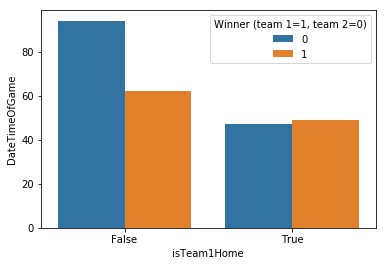

In [0]:
tt=traindf.groupby(['isTeam1Home',dependant])['DateTimeOfGame'].count()
td=pd.DataFrame(tt).reset_index()
print(td.head())
ax = sns.barplot(x="isTeam1Home", y="DateTimeOfGame", hue=dependant, data=td)

   Winner (team 1=1, team 2=0)  DateTimeOfGame
0                            0             141
1                            1             111


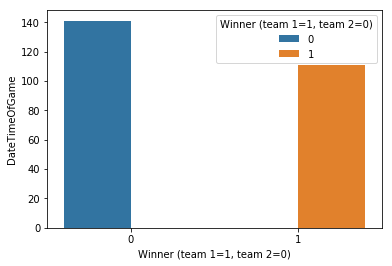

In [0]:
tt=traindf.groupby([dependant])['DateTimeOfGame'].count()
td=pd.DataFrame(tt).reset_index()
print(td.head())
ax = sns.barplot(x=dependant, y="DateTimeOfGame", hue=dependant, data=td)

  Now our dataframe is ready for training. We'll identify the columns to be selected and take a subset of the dataframe. We'll return X matrix and y vector